In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from loader import get_pricing_per_block, get_swap_data_per_block
from simulation import format_prices, run_simulation

In [2]:
swap_path = '../data/eth_price.csv'
price_data = get_pricing_per_block(swap_path, decimals_diff=12)
swap_data = get_swap_data_per_block(swap_path)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


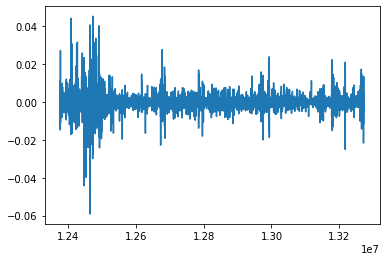

In [3]:
log_returns = np.log(1 + price_data.price.pct_change()).dropna()
log_returns.plot()

In [4]:
amount0 = swap_data[swap_data['amount0_adjusted']>0]['amount0_adjusted']
avg_amount0 = amount0.mean()

amount1 = swap_data[swap_data['amount1_adjusted']>0]['amount1_adjusted']
avg_amount1 = amount1.mean()
print(avg_amount0, avg_amount1)

330159.54466190195 109.51627121524783


In [5]:
#Setting up drift and random component in relation to asset data
u = log_returns.mean()
var = log_returns.var()
stdev = log_returns.std()
iterations = 100
duration = len(log_returns)+1
drift = u - 0.5*var
daily_returns = np.exp(0+ stdev * norm.ppf(np.random.rand(duration, iterations)))
#Takes last data point as startpoint point for simulation
S0 = price_data.price.iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0

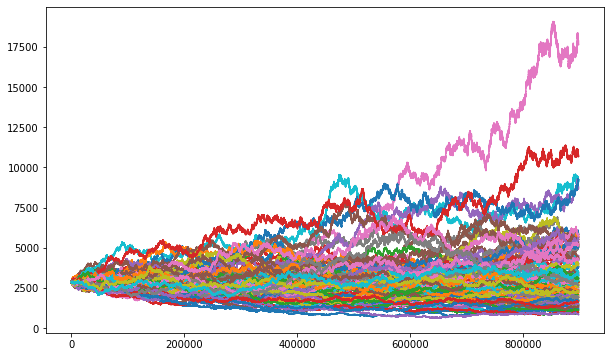

In [9]:
#Applies Monte Carlo simulation in asset
for t in range(1, duration):
    price_list[t] = price_list[t - 1] * daily_returns[t]

inverse_price_list = []
for t in range(0,duration):
    inverse_price_list.append(1/price_list[t])

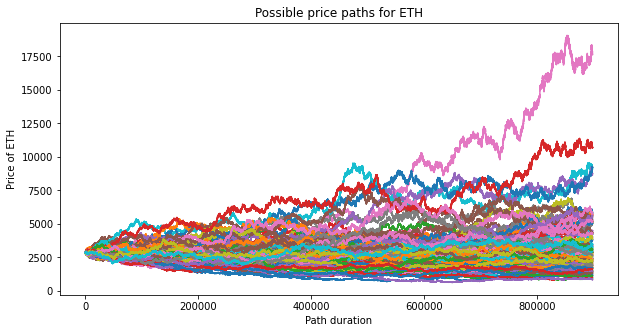

In [16]:
plt.figure(figsize=(10,5))
plt.plot(inverse_price_list)
plt.xlabel('Path duration')
plt.ylabel('Price of ETH')
plt.title('Possible price paths for ETH')
plt.show()

In [17]:
import pandas as pd
from liquidity import get_liquidity_based_usd
from utils import initialize_holdings, update_row, update_fees

In [18]:
def otm_range(price_df, params):
    range_percent = params['range_percent']
    is_complete = params['is_complete']
    ub = (price_df.price*(1 + range_percent/100)).dropna()
    if is_complete:
        lb = price_df.price*(1.0001)
    else:
        lb = ub/1.0001
    return lb, ub

In [19]:
out = Parallel(n_jobs=25, verbose=True)(delayed(run_simulation)
                (amount_invested=1e6, prices=format_prices(price_list[:,i], swap_data.index, swap_data['block_timestamp']), decimal_diff=12, get_range=otm_range, 
                 duration='14 day', params={'range_percent':30, 'is_complete':True},token_volumes=[avg_amount0, avg_amount1], tick_percent=5e-3, fee_teir=3e-3)
                for i in range(iterations))

[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 100 out of 100 | elapsed:  5.1min finished


In [20]:
def rets(out, index):
    mtm = out[index]['holdings'].usd_with_fees
    return round(100*(mtm.iloc[-1]-mtm.iloc[0])/mtm.iloc[0], 2)

In [21]:
returns = np.array([rets(out, index) for index in range(len(out))])
np.mean(returns)

18.863799999999998

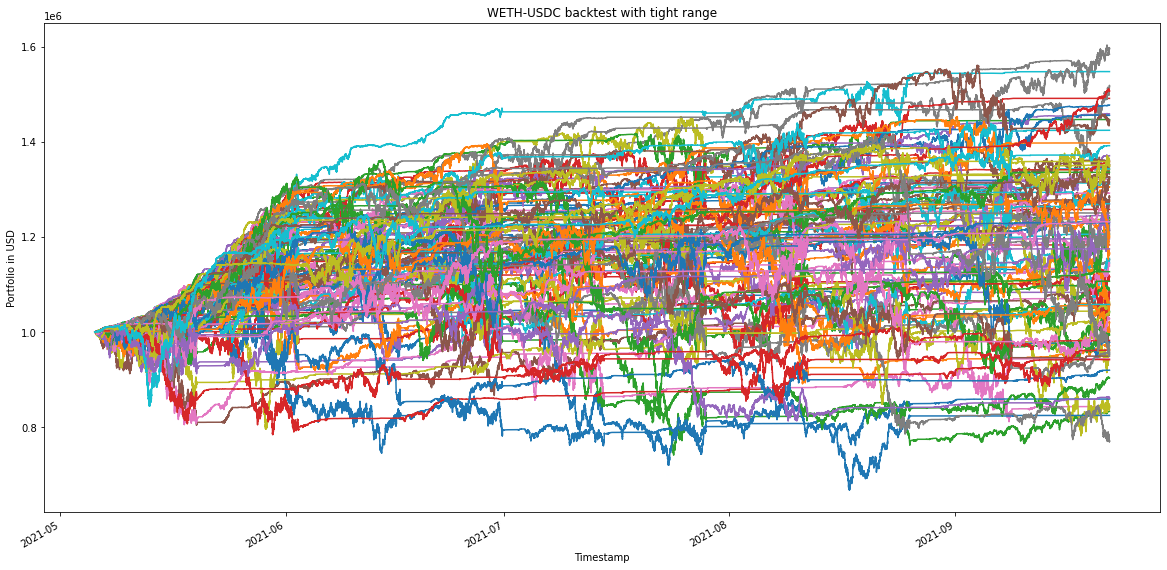

In [23]:
for i in range(len(out)):
    out[i]['holdings']['usd_with_fees'].plot(figsize=(20, 10))
plt.title(f'WETH-USDC backtest with tight range')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio in USD')
# plt.savefig(f'./results/With_Fees/{POOL_NAME}/{POOL_NAME}_backtest_with_all.png')
plt.show()

In [24]:
h = pd.Series(0, index=out[0]['holdings'].index)
for i in range(len(out)):
    h+=(out[i]['holdings']['usd_with_fees'])
h = h/len(out)

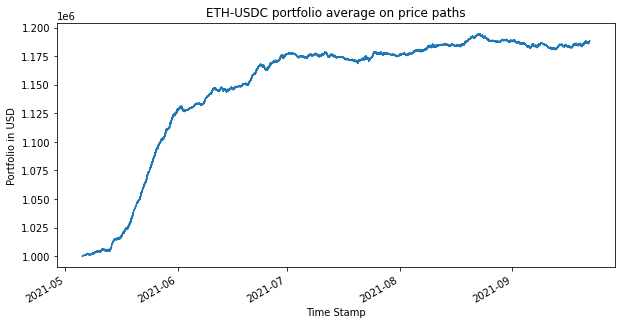

In [58]:
h.plot(figsize=(10,5))
plt.title(f'ETH-USDC portfolio average on price paths')
plt.xlabel('Time Stamp')
plt.ylabel('Portfolio in USD')
plt.show()

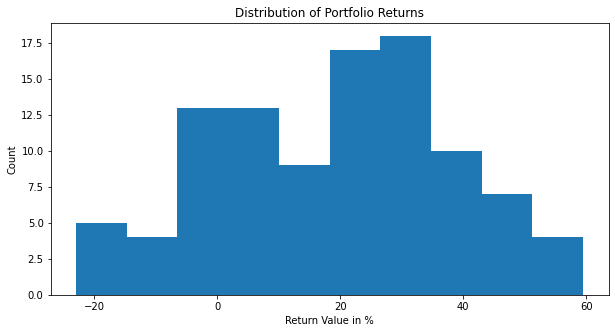

In [36]:
plt.figure(figsize=(10,5))
plt.hist(returns)
plt.title("Distribution of Portfolio Returns")
plt.ylabel("Count")
plt.xlabel("Return Value in %")
plt.show()

Text(0.5, 1.0, 'Portfolio value in USD')

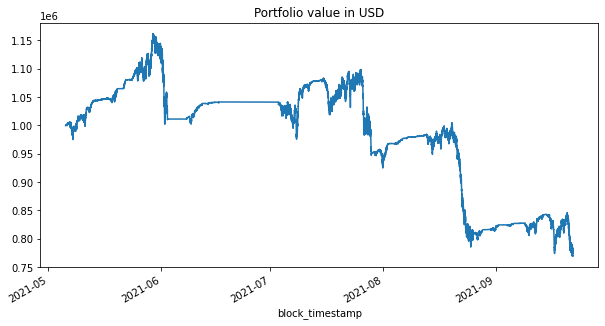

In [63]:
min_index = 0
min_ret = 0
for i in range(len(out)):
    ret = rets(out, i)
    if ret < min_ret:
        min_index = i
        min_ret = ret

out[min_index]['holdings'].usd_with_fees.plot(figsize=(10,5))
plt.title("Portfolio value in USD")

Text(0.5, 1.0, 'Price of ETH with ranges')

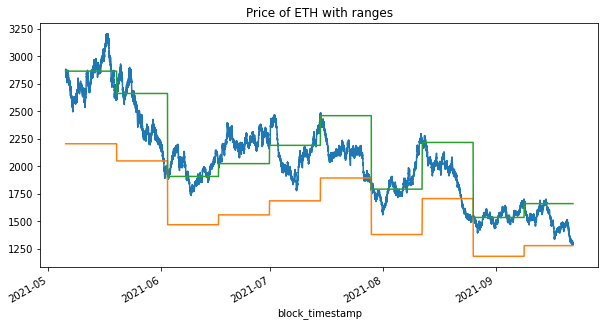

In [65]:
h  = out[min_index]['holdings']
cp, ub, lb = 1/h.cp, 1/h.ub, 1/h.lb
cp.plot(figsize=(10,5))
ub.plot()
lb.plot()
plt.title("Price of ETH with ranges")